# Computer vision: dog, cat or frog?

## Imports

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

import time
import datetime
import copy

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

## Data preparation

In [2]:
# generic
batch_size = 128
num_workers = 2

# data transformations
m = np.array([0.485, 0.456, 0.406])
s = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(m, s)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(m, s)
    ]),
}

print("Initializing datasets and dataloaders...")

# data path
DATA_PATH = './data_folder'

# create training and validation datasets
cifar10 = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=data_transforms['train'])
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True, transform=data_transforms['val'])

# obtain reduced datasets (dogs, cats and frogs)
label_map = {3: 0, 5: 1, 6: 2}
class_names = ['cat', 'dog', 'frog']
n_classes = len(class_names)

cifar3 = [(img, label_map[label]) for img, label in cifar10 if label in [3, 5, 6]]
cifar3_val = [(img, label_map[label]) for img, label in cifar10_val if label in [3, 5, 6]]
image_datasets = {'train': cifar3, 'val':cifar3_val}

# create training and validation dataloaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                   shuffle=True, num_workers=num_workers) for x in ['train', 'val']}

Initializing datasets and dataloaders...


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data_folder/cifar-10-python.tar.gz to ./data_folder
Files already downloaded and verified


In [3]:
# get device
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Device: {device}.")

Device: cuda.


## Look at some images

In [4]:
def show(imgs):
    mean = m
    std = s
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize = (10,10), ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = img.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
imgs, labs = next(iter(data_loaders['train']))
imgs = imgs[0:4, :, :, :]

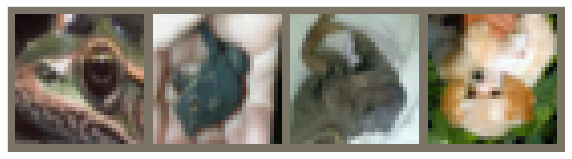

In [6]:
imgs_grid = make_grid(imgs)
show(imgs_grid)

## Helper functions

In [7]:
def check_params(model, verbose=False):

    '''Inspect model parameters'''

    modname = model.__class__.__name__
    print(f'Model: {modname}')

    tot = []
    for name, param in model.named_parameters():
        if param.requires_grad==True:
            tot.append(param.numel())
            if verbose:
                print(f'\t{name:<14}--> size: {param.numel():6}, shape: {param.shape}')
    
    print(f'Total number of parameters: {sum(tot)}')


def plot_history(log, fig_height=6):

    '''Given metric history for a model, plots metrics on epochs'''

    fig, axs = plt.subplots(ncols=2, figsize=(1.618*fig_height*2, fig_height))
    #sns.set_style('darkgrid')

    for i, ax in enumerate(axs.ravel()):

        metric = 'loss' if i==0 else 'acc'
        metric_name = 'cross entropy' if i==0 else 'accuracy'
        yt = np.array(log[metric]['train'])
        yv = np.array(log[metric]['val'])
        x = list(range(1, len(yv)+1))
        plotdata = pd.melt(pd.DataFrame({'epoch':x, 'train':yt, 'val':yv}), id_vars='epoch', value_name=metric, var_name='phase')
        
        sns.lineplot(ax=ax, x='epoch', y=metric, hue='phase', data=plotdata, palette=sns.color_palette('Dark2')[0:2])
        ax.set_xlabel('epochs',size=15)
        ax.set_ylabel(metric_name ,size=15)

    fig.suptitle(f'{model.__class__.__name__}', fontsize=18)


def compare_models(models_dict, phase='val', metric='acc', fig_height = 6):

    '''
    Given a model dictionary with model and logs, plot metric of interest
    on epochs for every model
    '''

    d = pd.DataFrame()
    for k, v in models_dict.items():
        d[str(k)] = v[1][metric][phase]

    d['epoch'] = list(range(1, len(d)+1))
    metric_name = 'cross entropy' if metric=='loss' else 'accuracy'
    plotdata = pd.melt(d, id_vars='epoch', value_name=metric_name, var_name='model')
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(1.618*fig_height, fig_height))
    #sns.set_style('darkgrid')
    sns.lineplot(ax=ax, x='epoch', y=metric_name,
                 hue='model', data=plotdata,
                 palette=sns.color_palette('Dark2')[0:(len(d.columns)-1)])
    ax.set_xlabel('epochs',size=15)
    ax.set_ylabel(metric_name ,size=15)
    ax.set_title('Model comparison',size=18)

In [8]:
models_dict = dict()

## Analysis

### Some simple nets

In [9]:
class VanillaNet(nn.Module):
    
    '''
    Combines convolutions and pooling to learn spatial features from images.
    This way, we achieve local operation on neighborhoods, translation 
    invariance, fewer parameters in the model.
    '''

    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # convolution + pooling
        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=n_chans1, kernel_size=3, padding=1))
        self.add_module('conv2', nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1//2, kernel_size=3, padding=1))
        
        # linear
        self.add_module('fc1', nn.Linear(n_chans1//2 * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class DropoutNet(nn.Module):

    '''
    Uses Dropout (2014), a procedure which amounts to zero out a proportion of 
    outputs after activation functions during training.
    Avoids overfitting and is somewhat similar to regularization/weight decay
    or data augmentation. Dropout2d zeroes 2D channels.
    '''

    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # convolution + pooling
        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=n_chans1, kernel_size=3, padding=1))
        self.add_module('conv2', nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1//2, kernel_size=3, padding=1))
        
        # linear
        self.add_module('fc1', nn.Linear(n_chans1//2 * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.dropout(F.max_pool2d(out, 2), p=0.4)
        out = torch.relu(self.conv2(out))
        out = F.dropout(F.max_pool2d(out, 2), p=0.4)
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class BatchnormNet(nn.Module):

    '''
    Uses Batch normalization (2015), which standardizes inputs using running 
    batch mean and std during training and uses whole data estimates during
    inference (inputs still need to be standardized beforehand).
    Acts as a regularizer (so is an alternative to dropout) and allows for
    greater learning rates
    '''

    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # convolution + batchnorm + pooling
        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=n_chans1, kernel_size=3, padding=1))
        self.add_module('bn1', nn.BatchNorm2d(num_features=n_chans1))
        self.add_module('conv2', nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1 // 2, kernel_size=3, padding=1))
        self.add_module('bn2', nn.BatchNorm2d(num_features=n_chans1 // 2))

        # linear
        self.add_module('fc1', nn.Linear(n_chans1//2 * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.bn2(self.conv2(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### Define training function

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    modelname = model.__class__.__name__
    start = time.time()

    loss_history = {'train': [], 'val': []}
    acc_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f'Training model {modelname}')
    print(datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"), '\n')
    print('*'*120, '\n')

    for epoch in range(1, num_epochs+1):
        
        start2 = time.time()
        epoch_loss_dict = dict()
        epoch_acc_dict = dict()

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            # metrics 
            running_loss = 0.0
            running_corrects = 0

            # iterate over batches
            for inputs, labels in dataloaders[phase]:

                # get data to the right device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track gradient history only if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # if training: backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # record epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            epoch_loss_dict[phase] = epoch_loss
            epoch_acc_dict[phase] = epoch_acc

            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc.cpu().item())

            # check for best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # end of epoch
        nowtime = datetime.datetime.now().strftime("%H:%M:%S")
        if epoch < 4 or epoch % 10 == 0:
            msg_loss = f"train_loss: {epoch_loss_dict['train']:.4f}  valid_loss: {epoch_loss_dict['val']:.4f}"
            msg_acc = f"train_acc: {epoch_acc_dict['train']:.4f}  valid_acc: {epoch_acc_dict['val']:.4f}"
            print(f'epoch {epoch}/{num_epochs}\t{msg_loss}  {msg_acc}   {nowtime}')

    # end of training
    time_elapsed = time.time() - start
    print()
    print('*'*120)
    print(f'\n{modelname} training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    log = {'loss': loss_history, 'acc': acc_history}

    return model, log

### Train the models

In [11]:
num_epochs = 100

**VanillaNet**

In [12]:
print('Getting training setup...\n')

model = VanillaNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: VanillaNet
Total number of parameters: 18123


In [13]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model VanillaNet
14/10/2022 20:18:07 

************************************************************************************************************************ 

epoch 1/100	train_loss: 1.0170  valid_loss: 0.9251  train_acc: 0.4721  valid_acc: 0.5490   20:18:13
epoch 2/100	train_loss: 0.9059  valid_loss: 0.8549  train_acc: 0.5673  valid_acc: 0.5840   20:18:15
epoch 3/100	train_loss: 0.8564  valid_loss: 0.8097  train_acc: 0.5867  valid_acc: 0.6020   20:18:16
epoch 10/100	train_loss: 0.7398  valid_loss: 0.7530  train_acc: 0.6541  valid_acc: 0.6353   20:18:23
epoch 20/100	train_loss: 0.6693  valid_loss: 0.6827  train_acc: 0.6893  valid_acc: 0.6743   20:18:33
epoch 30/100	train_loss: 0.6307  valid_loss: 0.6761  train_acc: 0.7164  valid_acc: 0.6790   20:18:43
epoch 40/100	train_loss: 0.5981  valid_loss: 0.6679  train_acc: 0.7317  valid_acc: 0.6847   20:18:54
epoch 50/100	train_loss: 0.5695  valid_loss: 0.6712  train_acc: 0.7465  valid_acc: 0.6897   20:19:04
epoch 60/100	train_loss:

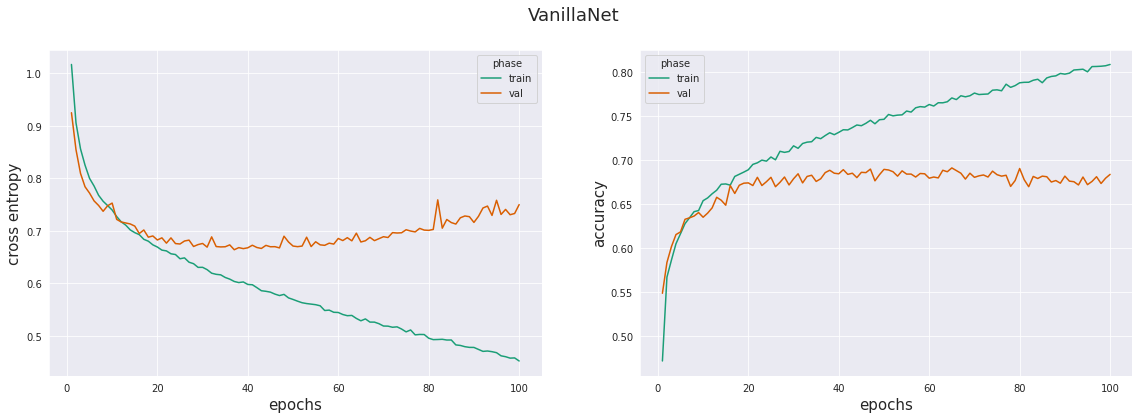

In [14]:
plot_history(log)

In [15]:
models_dict['VanillaNet'] = model, log

**DropoutNet**

In [16]:
print('Getting training setup...\n')

model = DropoutNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: DropoutNet
Total number of parameters: 18123


In [17]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model DropoutNet
14/10/2022 20:19:57 

************************************************************************************************************************ 

epoch 1/100	train_loss: 1.0600  valid_loss: 0.9803  train_acc: 0.4336  valid_acc: 0.5107   20:19:59
epoch 2/100	train_loss: 0.9455  valid_loss: 0.8889  train_acc: 0.5334  valid_acc: 0.5560   20:20:00
epoch 3/100	train_loss: 0.8947  valid_loss: 0.8524  train_acc: 0.5603  valid_acc: 0.5820   20:20:01
epoch 10/100	train_loss: 0.7630  valid_loss: 0.7532  train_acc: 0.6339  valid_acc: 0.6327   20:20:09
epoch 20/100	train_loss: 0.7205  valid_loss: 0.7247  train_acc: 0.6623  valid_acc: 0.6603   20:20:20
epoch 30/100	train_loss: 0.7052  valid_loss: 0.7173  train_acc: 0.6667  valid_acc: 0.6560   20:20:30
epoch 40/100	train_loss: 0.6896  valid_loss: 0.7070  train_acc: 0.6752  valid_acc: 0.6687   20:20:42
epoch 50/100	train_loss: 0.6772  valid_loss: 0.7069  train_acc: 0.6869  valid_acc: 0.6727   20:20:52
epoch 60/100	train_loss:

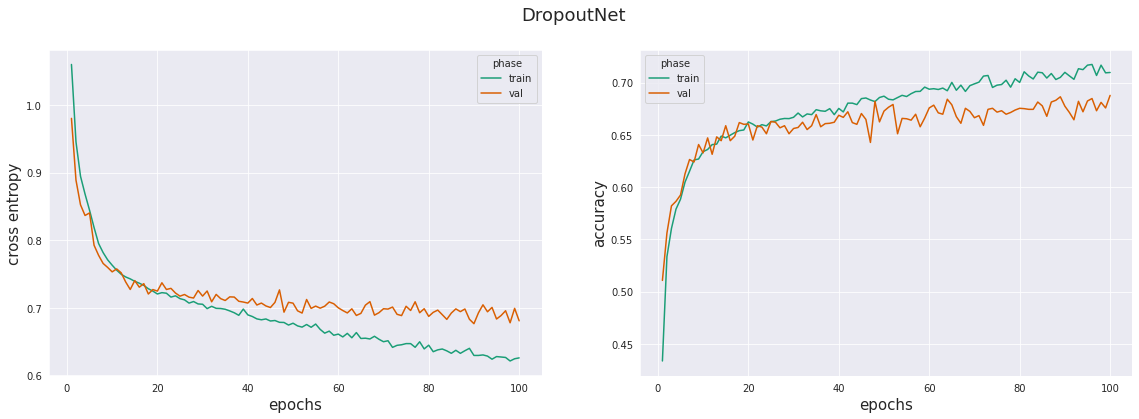

In [18]:
plot_history(log)

In [19]:
models_dict['DropoutNet'] = model, log

**BatchnormNet**

In [20]:
print('Getting training setup...\n')

model = BatchnormNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: BatchnormNet
Total number of parameters: 18171


In [21]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model BatchnormNet
14/10/2022 20:21:46 

************************************************************************************************************************ 

epoch 1/100	train_loss: 0.9568  valid_loss: 0.8372  train_acc: 0.5248  valid_acc: 0.5987   20:21:48
epoch 2/100	train_loss: 0.8052  valid_loss: 0.7638  train_acc: 0.6144  valid_acc: 0.6247   20:21:49
epoch 3/100	train_loss: 0.7490  valid_loss: 0.7260  train_acc: 0.6455  valid_acc: 0.6597   20:21:50
epoch 10/100	train_loss: 0.6373  valid_loss: 0.6723  train_acc: 0.7103  valid_acc: 0.6867   20:21:58
epoch 20/100	train_loss: 0.5671  valid_loss: 0.6364  train_acc: 0.7514  valid_acc: 0.7100   20:22:09
epoch 30/100	train_loss: 0.5209  valid_loss: 0.6284  train_acc: 0.7712  valid_acc: 0.7143   20:22:20
epoch 40/100	train_loss: 0.4807  valid_loss: 0.6388  train_acc: 0.7945  valid_acc: 0.7153   20:22:32
epoch 50/100	train_loss: 0.4444  valid_loss: 0.6636  train_acc: 0.8123  valid_acc: 0.7097   20:22:43
epoch 60/100	train_los

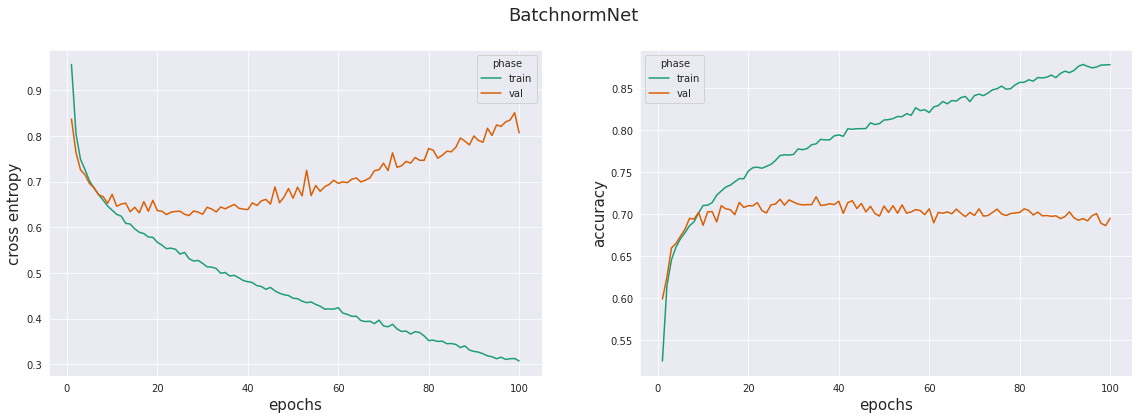

In [22]:
plot_history(log)

In [23]:
models_dict['BatchnormNet'] = model, log

**ConvNet**

In [24]:
class ConvBlock(nn.Module):

    '''Convolution block'''

    def __init__(self, in_chans, out_chans, kernel_size=3, padding=1,):
        super(ConvBlock, self).__init__()
        
        # convolution + batchnorm + dropout
        self.add_module('conv', nn.Conv2d(in_chans, out_chans,
                                          kernel_size=kernel_size, padding=padding, bias=False))
        self.add_module('bn', nn.BatchNorm2d(num_features=out_chans))

        # parameter initialization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bn.weight, 0.5)
        torch.nn.init.zeros_(self.bn.bias)
    
    def forward(self, x):
        out = F.dropout2d(torch.relu(self.bn(self.conv(x))), p=0.2)
        return out

class ConvNet(nn.Module):

    '''Combines convolutions, pooling, batch normalization and dropout'''

    def __init__(self, n_chans=16, n_blocks=2):
        super().__init__()

        self.n_chans = n_chans
        
        # first convolution
        self.add_module('conv1', ConvBlock(3, out_chans=n_chans))
        self.add_module('bn1', nn.BatchNorm2d(num_features=n_chans))

        # intermediate convolution blocks
        self.add_module('convblocks',
                        nn.Sequential(*(n_blocks * [ConvBlock(in_chans=n_chans, out_chans=n_chans)])))

        # linear
        self.add_module('fc1', nn.Linear(n_chans * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):

        out = torch.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        out = F.max_pool2d(self.convblocks(out), 2)
        out = out.view(-1, self.n_chans * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
print('Getting training setup...\n')

model = ConvNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: ConvNet
Total number of parameters: 35731


In [26]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model ConvNet
14/10/2022 20:23:41 

************************************************************************************************************************ 

epoch 1/100	train_loss: 1.0294  valid_loss: 0.9796  train_acc: 0.4627  valid_acc: 0.5157   20:23:42
epoch 2/100	train_loss: 0.9400  valid_loss: 0.9239  train_acc: 0.5439  valid_acc: 0.5647   20:23:44
epoch 3/100	train_loss: 0.9053  valid_loss: 0.9025  train_acc: 0.5593  valid_acc: 0.5623   20:23:45
epoch 10/100	train_loss: 0.8177  valid_loss: 0.8552  train_acc: 0.6115  valid_acc: 0.5900   20:23:53
epoch 20/100	train_loss: 0.7695  valid_loss: 0.8157  train_acc: 0.6415  valid_acc: 0.6223   20:24:06
epoch 30/100	train_loss: 0.7448  valid_loss: 0.8071  train_acc: 0.6550  valid_acc: 0.6270   20:24:18
epoch 40/100	train_loss: 0.7135  valid_loss: 0.7936  train_acc: 0.6721  valid_acc: 0.6410   20:24:30
epoch 50/100	train_loss: 0.6922  valid_loss: 0.7864  train_acc: 0.6820  valid_acc: 0.6473   20:24:45
epoch 60/100	train_loss: 0.

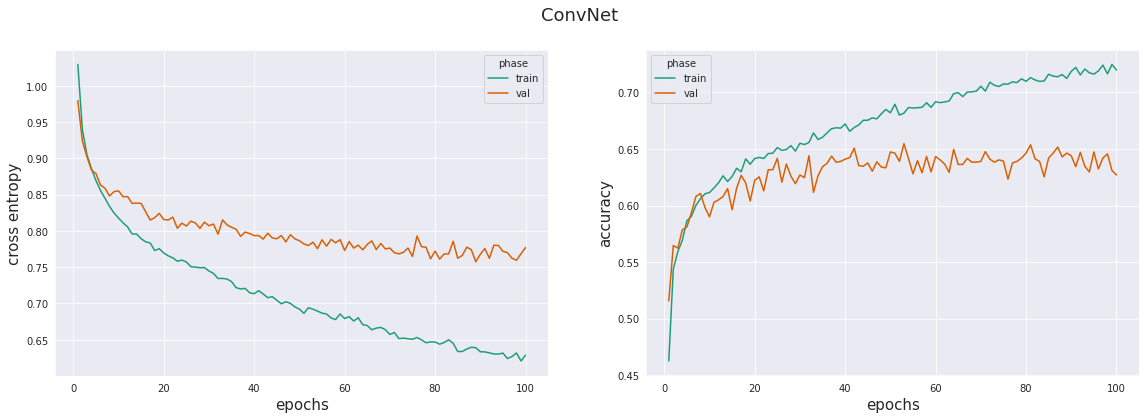

In [27]:
plot_history(log)

In [28]:
models_dict['ConvNet'] = model, log

**ResNet**

In [29]:
class ResBlock(nn.Module):

    '''ResNet intermediate block with skip connection'''

    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        
        # convolution + batchnorm
        self.add_module('conv', nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False))
        self.add_module('bn', nn.BatchNorm2d(num_features=n_chans))

        # parameter initialization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bn.weight, 0.5)
        torch.nn.init.zeros_(self.bn.bias)
    
    def forward(self, x):
        out = torch.relu(self.bn(self.conv(x)))
        return out + x

class DeepResNet(nn.Module):
    
    '''
    Residual nets (2015): deep net with multiple skip connections, which 
    alleviates the vanishing gradient problem allowing for deeper nets.
    Skip connection: out = layer(x) + x
    The structure is similar to torchvision pretrained ResNet50 etc. 
    '''
    
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # first convolution
        self.add_module('conv1', nn.Conv2d(3, n_chans1, kernel_size=3, padding=1))
        self.add_module('bn1', nn.BatchNorm2d(num_features=n_chans1))
        
        # resnet blocks with skip connection
        self.add_module('resblocks', nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)])))

        # linear
        self.add_module('fc1', nn.Linear(8 * 8 * n_chans1, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
print('Getting training setup...\n')

model = DeepResNet(n_blocks=3).to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: DeepResNet
Total number of parameters: 75907


In [31]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model DeepResNet
14/10/2022 20:25:48 

************************************************************************************************************************ 

epoch 1/100	train_loss: 0.9082  valid_loss: 0.7765  train_acc: 0.5491  valid_acc: 0.6223   20:25:49
epoch 2/100	train_loss: 0.7619  valid_loss: 0.7288  train_acc: 0.6359  valid_acc: 0.6530   20:25:51
epoch 3/100	train_loss: 0.7085  valid_loss: 0.6904  train_acc: 0.6718  valid_acc: 0.6760   20:25:52
epoch 10/100	train_loss: 0.5873  valid_loss: 0.6439  train_acc: 0.7387  valid_acc: 0.7050   20:26:02
epoch 20/100	train_loss: 0.4877  valid_loss: 0.6137  train_acc: 0.7865  valid_acc: 0.7293   20:26:16
epoch 30/100	train_loss: 0.4110  valid_loss: 0.6716  train_acc: 0.8272  valid_acc: 0.7153   20:26:30
epoch 40/100	train_loss: 0.3280  valid_loss: 0.7789  train_acc: 0.8698  valid_acc: 0.7040   20:26:43
epoch 50/100	train_loss: 0.2596  valid_loss: 0.7690  train_acc: 0.8995  valid_acc: 0.7127   20:26:57
epoch 60/100	train_loss:

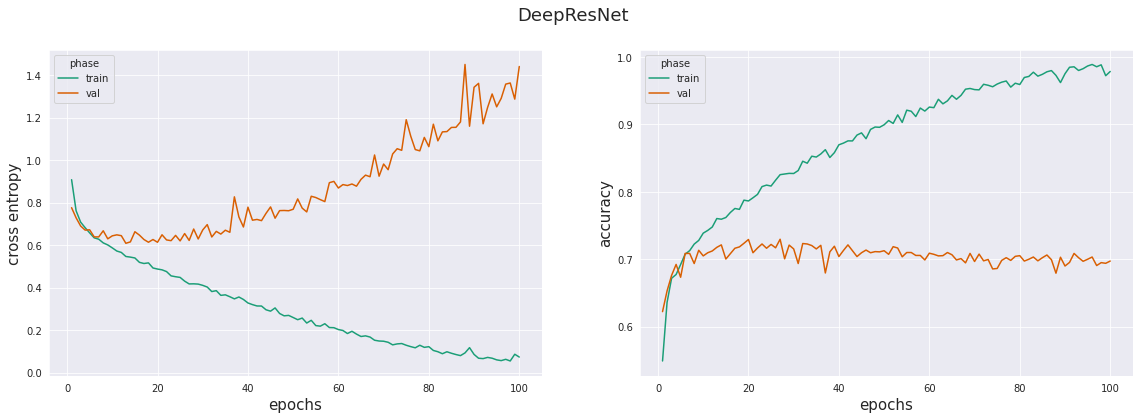

In [32]:
plot_history(log)

In [33]:
models_dict['DeepResNet'] = model, log

### Model comparison

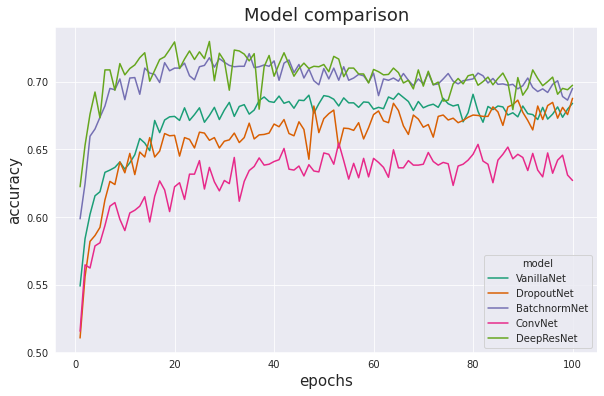

In [34]:
compare_models(models_dict)